In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from collections import namedtuple
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [2]:
# Define the Uncertainty named tuple
Uncertainty = namedtuple('Uncertainty', ['total', 'aleatoric', 'epistemic'])

In [4]:
def calculate_entropy_uncertainties(labels, end_leafs, leafs_split):
    """
    Based on the paper Shaker MH, Hüllermeier E. Aleatoric and epistemic uncertainty with random forests. In International Symposium on
    Intelligent Data Analysis 2020 Apr 27 (pp. 444-456). Springer, Cham. (https://arxiv.org/pdf/2001.00893.pdf)
    Given a single sample x, we calculate three types of uncertainties: total, aleatoric (statistical), and epistemic (information related).
    """
    n_labels = len(labels)
    tot_u = 0  # total uncertainty
    al_u = 0  # aleatoric uncertainty
    for label in labels:  # go over the labels
        tot_p = 0  # total uncertainty
        tot_p_log_p = 0  # helper for aleatoric uncertainty

        for i in range(len(leafs_split)):
            tree_leafs_split = leafs_split[i]
            end_leaf = end_leafs[i]

            # Calculate p(y | hi, x) for each tree ('hi') based on the leaf where each sample ends up
            p = _calculate_class_conditional_probabilities(label, n_labels, end_leaf, tree_leafs_split)
            tot_p += p
            tot_p_log_p += p * np.log2(p)
       
        # Total uncertainty for label i:
        mean_tot_p = tot_p / len(end_leafs)  # get the average over all trees
        log_mean_tot_p = np.log2(mean_tot_p)
        tot_u -= mean_tot_p * log_mean_tot_p  # equation 11

        # Aleatoric uncertainty for label i:
        mean_tot_p_log_p = tot_p_log_p / len(end_leafs)  # get the average over all trees
        al_u -= mean_tot_p_log_p
    return Uncertainty(tot_u, al_u, tot_u - al_u)

def _calculate_class_conditional_probabilities(label, n_labels, end_leaf, tree_leafs_split):
    """
    We calculate p(y | hi, x) for a given label y and a specific model(tree).
    """
    n_y = tree_leafs_split[end_leaf][label]
    n = sum(tree_leafs_split[end_leaf])
    return (n_y + 1) / (n + n_labels)

def Uncertainty_in_Pool(X_pool,rf_model):
    # Calculate end_leafs and leafs_split for a given sample x from the pool
    # Calculate uncertainties for all points in the pool
    pool_uncertainties = []
    for x_index in range(len(X_pool)):
        x = np.array([X_pool[x_index]], dtype=np.float32)  # Convert x to np.float32
        end_leafs = []
        leafs_split = []
        for estimator in rf_model.estimators_:
            tree = estimator.tree_
            leaf_id = tree.apply(x)[0]  # Apply x as a NumPy array
            leaf_samples = tree.value.squeeze()
            leaf_samples_dict = {label: count for label, count in enumerate(leaf_samples)}
            end_leafs.append(leaf_id)
            leafs_split.append(leaf_samples_dict)

        uncertainties = calculate_entropy_uncertainties([0, 1], end_leafs, leafs_split)
        pool_uncertainties.append(uncertainties)
    return pool_uncertainties

In [5]:
def Plot_contour(X,rf_model_tot,rf_model_AL,rf_model_Ep,X_pool_tot,y_pool_tot,X_labeled_tot,y_labeled_tot,x_selected_tot,X_pool_AL,y_pool_AL,X_labeled_AL,y_labeled_AL,x_selected_AL,X_pool_Ep,y_pool_Ep,X_labeled_Ep,y_labeled_Ep,x_selected_Ep):
     # plot the uncertainty
    h = 0.02  # Step size in the mesh
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    xy_pairs = np.c_[xx.ravel(), yy.ravel()]
    # calculate uncertainty
    #uncertainties_3 = calculate_uncertainty_SmallestMargin(xy_pairs, model_SM)
    contour_uncertainties_tot = []
    for x_index in range(xy_pairs.shape[0]):
        x = np.array([xy_pairs[x_index]], dtype=np.float32)  # Convert x to np.float32
        end_leafs = []
        leafs_split = []
        for estimator in rf_model_tot.estimators_:
            tree = estimator.tree_
            leaf_id = tree.apply(x)[0]  # Apply x as a NumPy array
            leaf_samples = tree.value.squeeze()
            leaf_samples_dict = {label: count for label, count in enumerate(leaf_samples)}
            end_leafs.append(leaf_id)
            leafs_split.append(leaf_samples_dict)

        uncertainties = calculate_entropy_uncertainties([0, 1], end_leafs, leafs_split)
        contour_uncertainties_tot.append(uncertainties)

    contour_uncertainties_AL = []
    for x_index in range(xy_pairs.shape[0]):
        x = np.array([xy_pairs[x_index]], dtype=np.float32)  # Convert x to np.float32
        end_leafs = []
        leafs_split = []
        for estimator in rf_model_AL.estimators_:
            tree = estimator.tree_
            leaf_id = tree.apply(x)[0]  # Apply x as a NumPy array
            leaf_samples = tree.value.squeeze()
            leaf_samples_dict = {label: count for label, count in enumerate(leaf_samples)}
            end_leafs.append(leaf_id)
            leafs_split.append(leaf_samples_dict)

        uncertainties = calculate_entropy_uncertainties([0, 1], end_leafs, leafs_split)
        contour_uncertainties_AL.append(uncertainties)
        
    contour_uncertainties_Ep = []
    for x_index in range(xy_pairs.shape[0]):
        x = np.array([xy_pairs[x_index]], dtype=np.float32)  # Convert x to np.float32
        end_leafs = []
        leafs_split = []
        for estimator in rf_model_Ep.estimators_:
            tree = estimator.tree_
            leaf_id = tree.apply(x)[0]  # Apply x as a NumPy array
            leaf_samples = tree.value.squeeze()
            leaf_samples_dict = {label: count for label, count in enumerate(leaf_samples)}
            end_leafs.append(leaf_id)
            leafs_split.append(leaf_samples_dict)

        uncertainties = calculate_entropy_uncertainties([0, 1], end_leafs, leafs_split)
        contour_uncertainties_Ep.append(uncertainties)

    # Reshape uncertainties to match the shape of the meshgrid
    contour_uncertainties_tot=np.array(contour_uncertainties_tot)
    contour_uncertainties_AL=np.array(contour_uncertainties_AL)
    contour_uncertainties_Ep=np.array(contour_uncertainties_Ep)
    Tot_U=contour_uncertainties_tot[:,0]
    Aleatoric_U=contour_uncertainties_AL[:,1]
    Epistemic_U=contour_uncertainties_Ep[:,2]

    Tot_U = Tot_U.reshape(xx.shape)
    Aleatoric_U = Aleatoric_U.reshape(xx.shape)
    Epistemic_U = Epistemic_U.reshape(xx.shape)
    # Create a figure with three subplots
    fig, axs = plt.subplots(1, 3, figsize=(13, 5))
    im0 = axs[0].scatter(X_pool_tot[y_pool_tot==0, 0], X_pool_tot[y_pool_tot==0, 1], c='red', marker='+')
    im0 = axs[0].scatter(X_pool_tot[y_pool_tot==1, 0], X_pool_tot[y_pool_tot==1, 1], c='green', marker='+')
    im0 = axs[0].scatter(X_labeled_tot[y_labeled_tot==0, 0], X_labeled_tot[y_labeled_tot==0, 1], c='red', marker='o')
    im0 = axs[0].scatter(X_labeled_tot[y_labeled_tot==1, 0], X_labeled_tot[y_labeled_tot==1, 1], c='green', marker='o')
    im0 = axs[0].scatter(x_selected_tot[0, 0], x_selected_tot[:, 1], c='black', marker='s')
    contour1 = axs[0].contourf(xx, yy, Tot_U, alpha=0.4, cmap='viridis')
    axs[0].set_xlabel('Feature 1')
    axs[0].set_ylabel('Feature 2')
    axs[0].set_title('Total Uncertainty Contour Plot Entropy')
    im1 = axs[1].scatter(X_pool_AL[y_pool_AL==0, 0], X_pool_AL[y_pool_AL==0, 1], c='red', marker='+')
    im1 = axs[1].scatter(X_pool_AL[y_pool_AL==1, 0], X_pool_AL[y_pool_AL==1, 1], c='green', marker='+')
    im1 = axs[1].scatter(X_labeled_AL[y_labeled_AL==0, 0], X_labeled_AL[y_labeled_AL==0, 1], c='red', marker='o')
    im1 = axs[1].scatter(X_labeled_AL[y_labeled_AL==1, 0], X_labeled_AL[y_labeled_AL==1, 1], c='green', marker='o')
    im1 = axs[1].scatter(x_selected_AL[0, 0], x_selected_AL[:, 1], c='black', marker='s')
    contour1 = axs[1].contourf(xx, yy, Aleatoric_U, alpha=0.4, cmap='viridis')
    axs[1].set_xlabel('Feature 1')
    axs[1].set_ylabel('Feature 2')
    axs[1].set_title('Aleatoric Uncertainty Contour Plot Entropy')
    
    im2 = axs[2].scatter(X_pool_Ep[y_pool_Ep==0, 0], X_pool_Ep[y_pool_Ep==0, 1], c='red', marker='+', label='Unlabeled Point (C0)')
    im2 = axs[2].scatter(X_pool_Ep[y_pool_Ep==1, 0], X_pool_Ep[y_pool_Ep==1, 1], c='green', marker='+', label='Unlabeled Point (C1)')
    im2 = axs[2].scatter(X_labeled_Ep[y_labeled_Ep==0, 0], X_labeled_Ep[y_labeled_Ep==0, 1], c='red', marker='o', label='Labeled Point (C0)')
    im2 = axs[2].scatter(X_labeled_Ep[y_labeled_Ep==1, 0], X_labeled_Ep[y_labeled_Ep==1, 1], c='green', marker='o', label='Labeled Point (C1)')
    im2 = axs[2].scatter(x_selected_Ep[0, 0], x_selected_Ep[:, 1], c='black', marker='s', label='Selected point')
    contour1 = axs[2].contourf(xx, yy, Epistemic_U, alpha=0.4, cmap='viridis')
    axs[2].set_xlabel('Feature 1')
    axs[2].set_ylabel('Feature 2')
    axs[2].set_title('Epistemic Uncertainty Contour Plot Entropy')

    # Create a common colorbar for all subplots
    cbar_ax = fig.add_axes([0.96, 0.15, 0.02, 0.7])  # Position of the colorbar
    fig.colorbar(contour1, cax=cbar_ax, label='Uncertainty')
    fig.legend(loc='upper center', ncol=4)
    plt.tight_layout(pad=4)  # Adjusted padding value
    plt.show()

In [6]:
# Load the Iris dataset
iris = load_iris()
X, y = iris.data[:, :2], iris.target
X, y = shuffle(X, y, random_state=42)

# Consider only two classes (0 and 1)
X = X[y < 2]
y = y[y < 2]

In [7]:
# Split the data into labeled and pool sets
X_labeled, X_pool, y_labeled, y_pool = train_test_split(X, y, test_size=0.9, stratify=y, random_state=42)

X_labeled_tot = X_labeled_AL = X_labeled_Ep = X_labeled
y_labeled_tot = y_labeled_AL = y_labeled_Ep = y_labeled
X_pool_tot = X_pool_AL = X_pool_Ep = X_pool
y_pool_tot = y_pool_AL = y_pool_Ep = y_pool

In [10]:
# Train a random forest model on the labeled data
n_estimators = 10
random_state = 42
rf_model_tot = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
rf_model_AL = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
rf_model_Ep = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
rf_model_tot.fit(X_labeled_tot, y_labeled_tot)
rf_model_AL.fit(X_labeled_AL, y_labeled_AL)
rf_model_Ep.fit(X_labeled_Ep, y_labeled_Ep)
labels = [0, 1]  # Possible labels
# Calculate end_leafs and leafs_split for a given sample x from the pool
# Calculate uncertainties for all points in the pool

pool_uncertainties=Uncertainty_in_Pool(X_pool,rf_model_tot)
pool_uncertainties_tot=pool_uncertainties
pool_uncertainties_AL=pool_uncertainties
pool_uncertainties_Ep=pool_uncertainties

C:\Users\engal\AppData\Local\Temp\ipykernel_8732\3150421276.py:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=4)  # Adjusted padding value


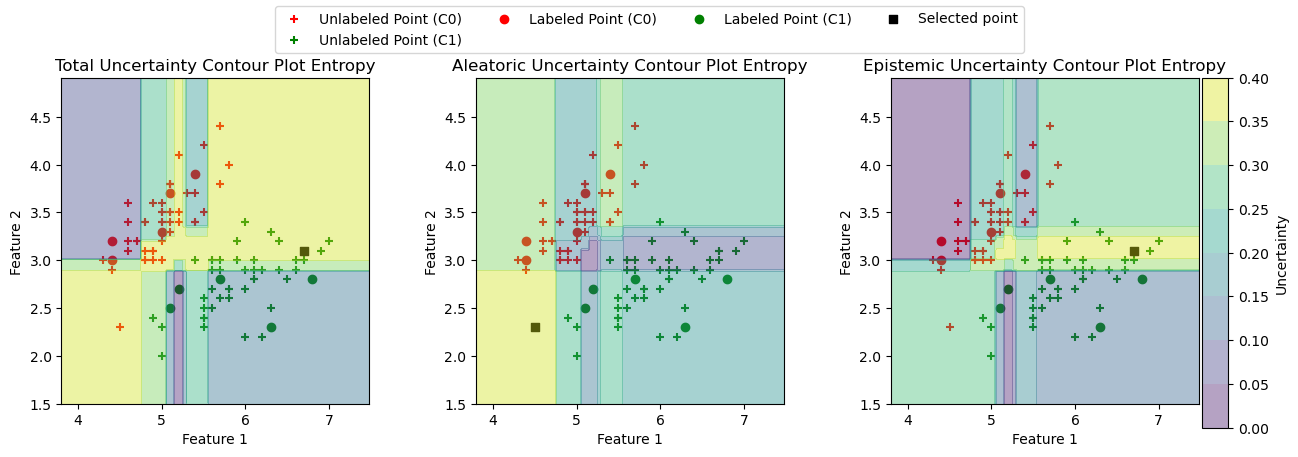

C:\Users\engal\AppData\Local\Temp\ipykernel_8732\3150421276.py:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=4)  # Adjusted padding value


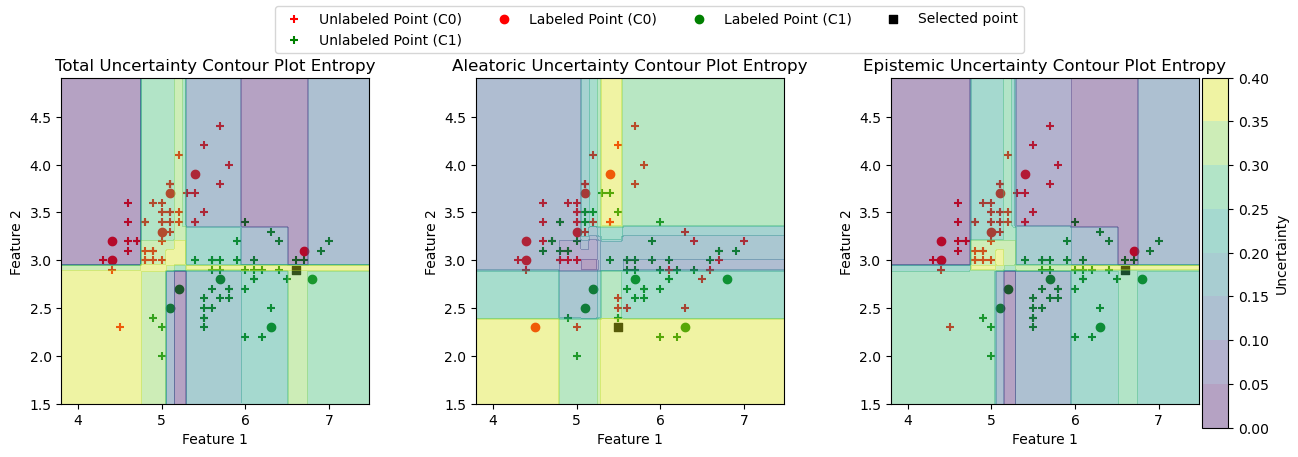

C:\Users\engal\AppData\Local\Temp\ipykernel_8732\3150421276.py:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=4)  # Adjusted padding value


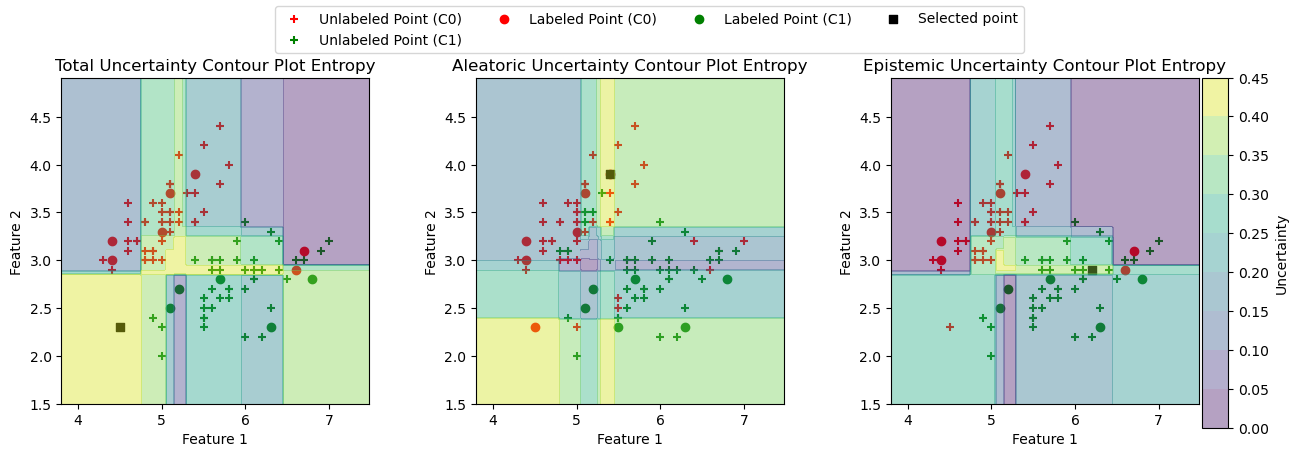

C:\Users\engal\AppData\Local\Temp\ipykernel_8732\3150421276.py:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=4)  # Adjusted padding value


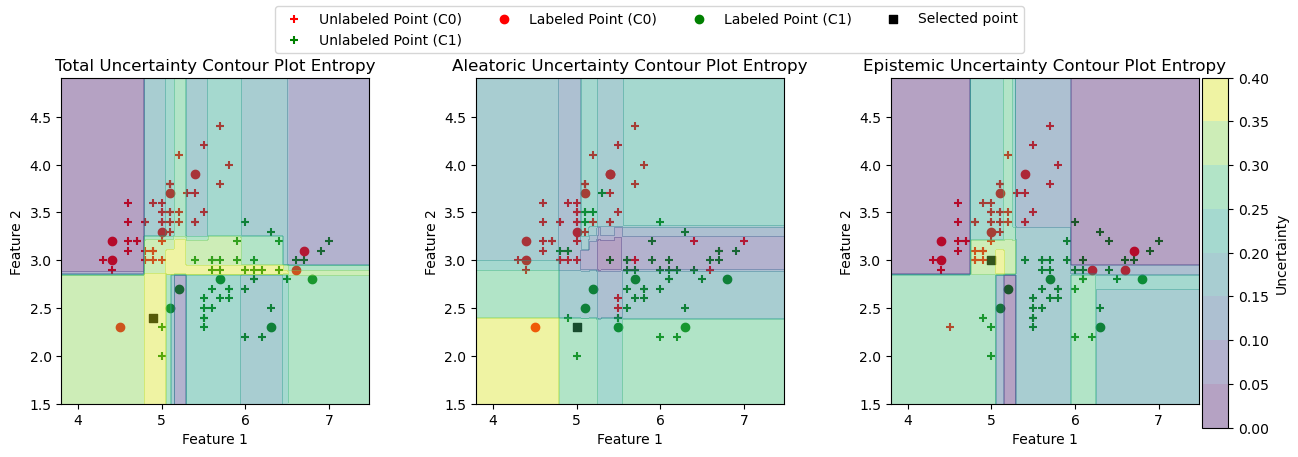

C:\Users\engal\AppData\Local\Temp\ipykernel_8732\3150421276.py:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=4)  # Adjusted padding value


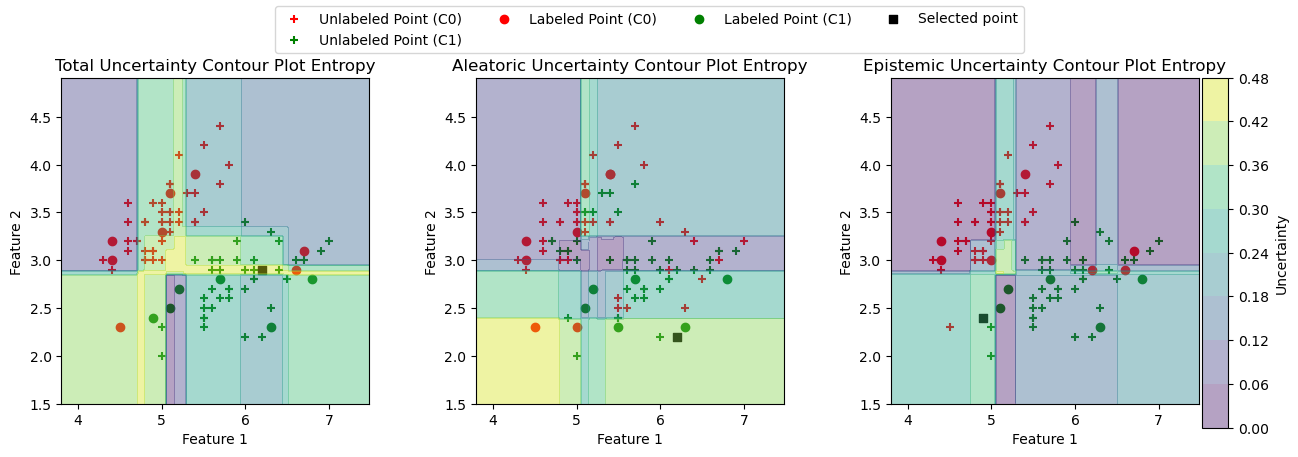

In [11]:
# Select the most uncertain point iteratively
selected_indices_tot, selected_indices_AL, selected_indices_Ep = [], [], []
num_iterations = 5  # Number of iterations for selecting uncertain points
for _ in range(num_iterations):
    max_uncertainty_index = np.argmax([u.total for u in pool_uncertainties_tot])
    AL_uncertainty_index = np.argmax([u.aleatoric for u in pool_uncertainties_AL])
    Ep_uncertainty_index = np.argmax([u.epistemic for u in pool_uncertainties_Ep])
    selected_indices_tot.append(max_uncertainty_index)
    selected_indices_AL.append(AL_uncertainty_index)
    selected_indices_Ep.append(Ep_uncertainty_index)
    x_selected_tot = np.array([X_pool_tot[max_uncertainty_index]], dtype=np.float32)
    x_selected_AL = np.array([X_pool_AL[AL_uncertainty_index]], dtype=np.float32)
    x_selected_Ep = np.array([X_pool_Ep[Ep_uncertainty_index]], dtype=np.float32)
    # plot contour
    Plot_contour(X,rf_model_tot,rf_model_AL,rf_model_Ep,X_pool_tot,y_pool_tot,X_labeled_tot,y_labeled_tot,x_selected_tot,X_pool_AL,y_pool_AL,X_labeled_AL,y_labeled_AL,x_selected_AL,X_pool_Ep,y_pool_Ep,X_labeled_Ep,y_labeled_Ep,x_selected_Ep)

    # Add the selected point to the labeled data
    X_labeled_tot = np.concatenate([X_labeled_tot, x_selected_tot])
    y_labeled_tot = np.concatenate([y_labeled_tot, rf_model_tot.predict(x_selected_tot)])
    X_labeled_AL = np.concatenate([X_labeled_AL, x_selected_AL])
    y_labeled_AL = np.concatenate([y_labeled_AL, rf_model_AL.predict(x_selected_AL)])
    X_labeled_Ep = np.concatenate([X_labeled_Ep, x_selected_Ep])
    y_labeled_Ep = np.concatenate([y_labeled_Ep, rf_model_Ep.predict(x_selected_Ep)])

    # Remove the selected point from the pool
    X_pool_tot = np.delete(X_pool_tot, max_uncertainty_index, axis=0)
    y_pool_tot = np.delete(y_pool_tot, max_uncertainty_index, axis=0)
    X_pool_AL = np.delete(X_pool_AL, AL_uncertainty_index, axis=0)
    y_pool_AL = np.delete(y_pool_AL, Ep_uncertainty_index, axis=0)
    X_pool_Ep = np.delete(X_pool_Ep, Ep_uncertainty_index, axis=0)
    y_pool_Ep = np.delete(y_pool_Ep, Ep_uncertainty_index, axis=0)

    # Re-fit the random forest model on the updated labeled data
    rf_model_tot.fit(X_labeled_tot, y_labeled_tot)
    rf_model_AL.fit(X_labeled_AL, y_labeled_AL)
    rf_model_Ep.fit(X_labeled_Ep, y_labeled_Ep)

    # Calculate uncertainties for the remaining points in the pool
    pool_uncertainties_tot=Uncertainty_in_Pool(X_pool_tot,rf_model_tot)
    pool_uncertainties_AL=Uncertainty_in_Pool(X_pool_AL,rf_model_AL)
    pool_uncertainties_Ep=Uncertainty_in_Pool(X_pool_Ep,rf_model_Ep)
    # Print the selected indices

In [12]:
print("Selected Indices:", selected_indices_tot)
print("Selected Indices:", selected_indices_AL)
print("Selected Indices:", selected_indices_Ep)

Selected Indices: [9, 41, 61, 17, 25]
Selected Indices: [63, 13, 19, 42, 12]
Selected Indices: [9, 41, 26, 4, 16]
